In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import time
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, tree
import xgboost

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, auc
import statsmodels.api as sm

import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

## Problems
- Penyakit jantung atau biasa disebut dengan Cardiovascular Disease (CVD) adalah penyakit yang terjadi di jantung atau pembuluh darah.
- Di Amerika, sekita 647,000 orang meninggal akibat penyakit jantung tiap tahunnya
- Penyakit jantung adalah salah satu penyebab kematian dari berbagai etnis, termasuk African Americans, Hispanic dan Whites. Untuk bebrapa etnis seperti American Indians atau Alaskan dan Asians, penyakit jantung merupakan penyakit kedua terparah setelah kanker.
- Untuk menanggulangi permasalahan diatas, diperlukan pendeteksi penyakit jantung secara dini karena kambuhnya penyakit jantung bisa jadi mendadak
- Tanda-tanda penyakit jantung dari badan kadang tidak terasa, oleh karena itu, diperlukan informasi mengenai pengukuran tubuh di laboratorium seperti salah satunya tekanan darah atau kadar kolesterol, tekanan darah dan lain-lain.
- Belum ada tes yang mendeteksi apakah pasien bisa saja terkena serangan jantung mendadak di kemudian hari

Source: https://www.cdc.gov/heartdisease/facts.htm

## Goals
- Memprediksi apakah pasien terkena heart disease atau tidak berdasarkan informasi dan health measurement yang terdapat pada dataset.
- Mengetahui apakah jenis kelamin yang rentan terhadap penyakit jantung
- Mengetahui rentang usia yang rentan terhadap penyakit jantung
- Mengetahui kadar kolesterol berapa yang menyebabkan penyakit jantung


- Fitur yang akan dijadikan target/label
    - 1: heart disease
    - 0: no heart disease


## Attributes Information

|Variable Name|Description|Data Type|
|:--|:--|:--|
|Age | Age | integer |
|Sex | Gender (1=Male, 0=Female)| integer |
| cp | Chest Pain (typical, asymptotic, nonanginal, nontypical) | integer |
| trestbos | Resting Blood Pressure| integer  | 
| chol| Serum cholestoral in mg/dl | integer  |
|fbs |Fasting blood sugar > 120 mg/dl | integer  |
| restecg | Resting electrocardiographic results | integer  |
| thalach | The person's maximum heart rate achieved | integer |
|exang| Exercise induced angine | integer |
|oldpeak| ST depression induced by exercise relative to rest | float|
|slope | slope of the peak exercise ST segment | integer  |
|ca | Number of major vessels colored by flouroscopy (0 - 3) | integer |
|thal | (3 = normal, 6=fixed defect, 7=reversable defect) | integer  |
|target | AHD - Diagnosis of heart disease (1 = yes, 0= no)| integer  |

## Import Dataset

In [2]:
df_import = pd.read_csv('https://raw.githubusercontent.com/Lecturer-Jcds/Machine-Learning-Exam/master/heart.csv')
df_import.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Check Null Values & Handling Missing Values

In [3]:
df_import.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

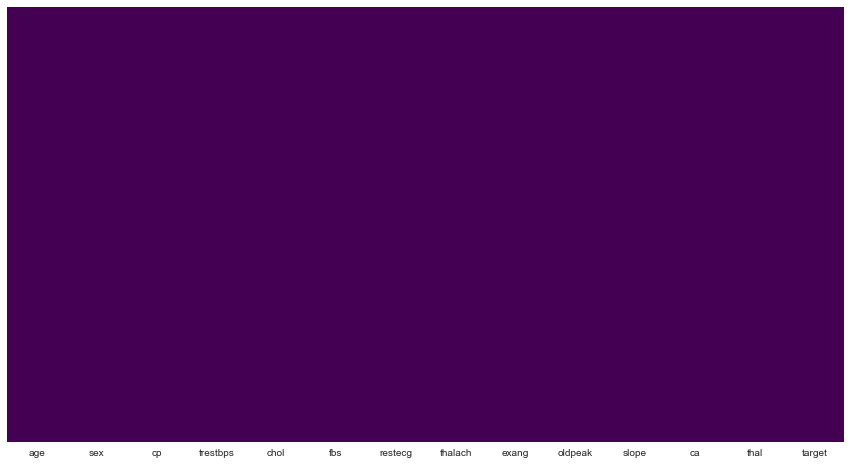

In [4]:
plt.figure(figsize=(15, 8))

sns.heatmap(df_import.isna(), yticklabels=False, cmap='viridis', cbar=False)

Tidak ada null value pada dataset. Oleh karena itu, tidak akan dilakukan imputasi.

## Check Outlier

In [5]:
def detect_lower_upper(col):
    q25 = col.quantile(0.25)
    q75 = col.quantile(0.75)
    iqr = q75 - q25
    cutoff = iqr*1.5
    lower = q25 - cutoff
    upper = q75 + cutoff
    return lower, upper

In [6]:
detect_lower_upper(df_import)

(age          27.25
 sex          -1.50
 cp           -3.00
 trestbps     90.00
 chol        115.75
 fbs           0.00
 restecg      -1.50
 thalach      84.75
 exang        -1.50
 oldpeak      -2.40
 slope        -0.50
 ca           -1.50
 thal          0.50
 target       -1.50
 dtype: float64,
 age          81.25
 sex           2.50
 cp            5.00
 trestbps    170.00
 chol        369.75
 fbs           0.00
 restecg       2.50
 thalach     214.75
 exang         2.50
 oldpeak       4.00
 slope         3.50
 ca            2.50
 thal          4.50
 target        2.50
 dtype: float64)

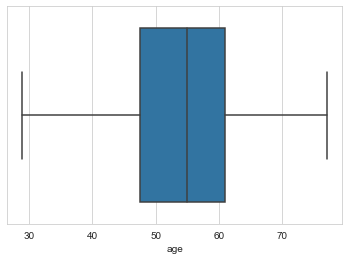

In [7]:
sns.boxplot(x=df_import["age"])

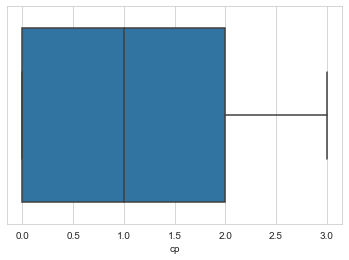

In [8]:
sns.boxplot(x=df_import["cp"])

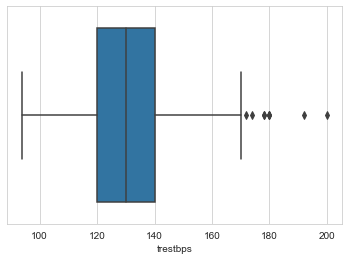

In [9]:
sns.boxplot(x=df_import["trestbps"])

Terdapat Outlier pada Resting Blood Pressure. Outlier ini kemudian akan dibiarkan karena penyakit jantung dapat disebabkan oleh trestbps yang sangat tinggi maupun yang sangat rendah.

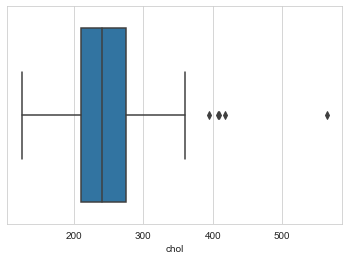

In [10]:
sns.boxplot(x=df_import["chol"])

Terdapat outlier pada kadar kolesterol. Outlier ini kemudian akan dibiarkan karena kadar kolesterol tinggi merupakan penyebab penyakit jantung akan semakin meningkat.

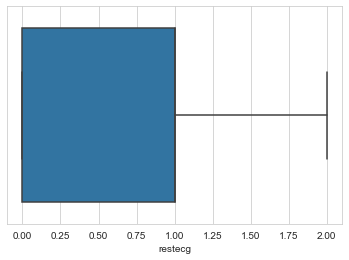

In [11]:
sns.boxplot(x=df_import["restecg"])

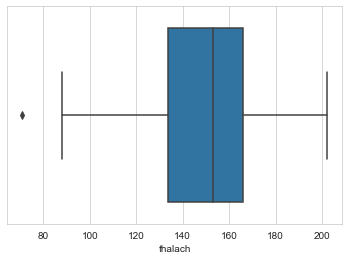

In [12]:
sns.boxplot(x=df_import["thalach"])

Maksimum pasien detak jantung ada yang dibawah peak, hal ini akan dimasukan kedalam predictor. Oleh karena itu, outlier tidak akan dihapus.

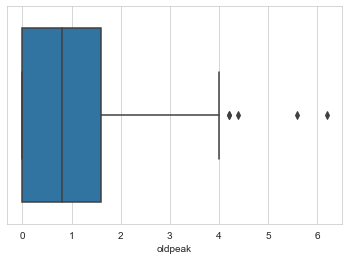

In [13]:
sns.boxplot(x=df_import["oldpeak"])

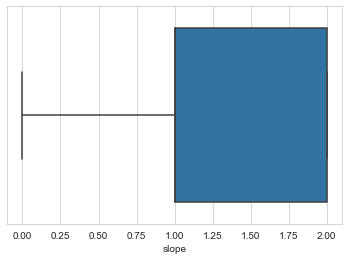

In [14]:
sns.boxplot(x=df_import["slope"])

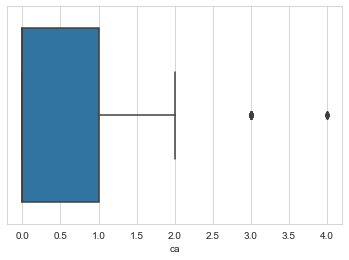

In [15]:
sns.boxplot(x=df_import["ca"])

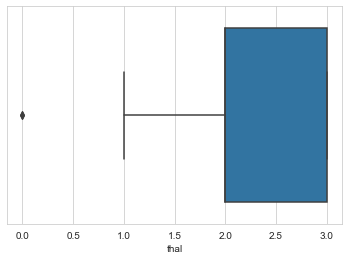

In [16]:
sns.boxplot(x=df_import["thal"])

## Describe Data

In [17]:
df_import.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [18]:
df_import.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [19]:
df_import['target'].value_counts()

1    165
0    138
Name: target, dtype: int64

In [20]:
len(df_import)

303

## Dataset Summary

In [21]:
df_summary = pd.DataFrame({
    'dataFeature': df_import.columns,
    'data_type': [df_import[i].dtypes for i in df_import.columns],
    'null_value_total': [df_import[i].isnull().sum() for i in df_import.columns],
    'null_value_%': [round(df_import[i].isnull().sum()/len(df_import) * 100, 2) for i in df_import.columns],
    'unique_value_total': [df_import[i].nunique() for i in df_import.columns],
    'uniqueSample': [df_import[i].drop_duplicates().sample(2).values for i in df_import.columns],
    'length': [df_import[i].shape[0] for i in df_import.columns],
    
})
df_summary

,dataFeature,data_type,null_value_total,null_value_%,unique_value_total,uniqueSample,length
0,age,int64,0,0.0,41,"[71, 29]",303
1,sex,int64,0,0.0,2,"[0, 1]",303
2,cp,int64,0,0.0,4,"[0, 3]",303
3,trestbps,int64,0,0.0,49,"[118, 110]",303
4,chol,int64,0,0.0,152,"[199, 315]",303
5,fbs,int64,0,0.0,2,"[1, 0]",303
6,restecg,int64,0,0.0,3,"[0, 1]",303
7,thalach,int64,0,0.0,91,"[127, 202]",303
8,exang,int64,0,0.0,2,"[1, 0]",303
9,oldpeak,float64,0,0.0,40,"[2.9, 0.3]",303


## Exploratory Data Analysis

### Membuat Fitur Baru

In [22]:
df1 = df_import.copy()

In [23]:
def sex_cat(x):
    if x == 0:
        return 'female'
    else:
        return 'male'
    
def target_cat(x):
    if x == 0:
        return 'no heart disease' # 0: no
    else:
        return 'heart disease' # 1: yes
    
def cp_cat(x):
    if x == 0:
        return 'typical '
    elif x == 1:
        return 'asymptotic'
    elif x == 2:
        return 'nonanginal'
    else:
        return 'nontypical'
    
def chol_cat(x):
    if x <= 200:
        return '1_normal'
    elif 201 <= x <= 239:
        return '2_high'
    else:
        return '3_very high'
    
    
df1['sex_cat'] = df1['sex'].apply(sex_cat)
df1['target_cat'] = df1['target'].apply(target_cat)
df1['cp_cat'] = df1['cp'].apply(cp_cat)
df1['chol_cat'] = df1['chol'].apply(chol_cat)

## Correlation Matrix

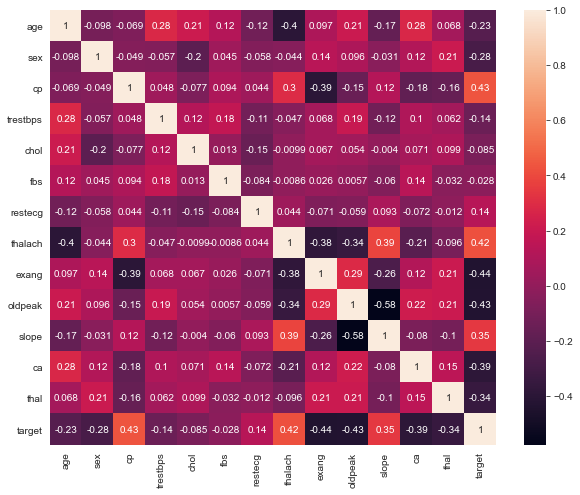

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_import.corr(), annot=True)

Spearman Correlation digunakan untuk mengukur hubungan korelasi antara 2 variable yang diantaranya ada yang tidak terdistribusi normal.

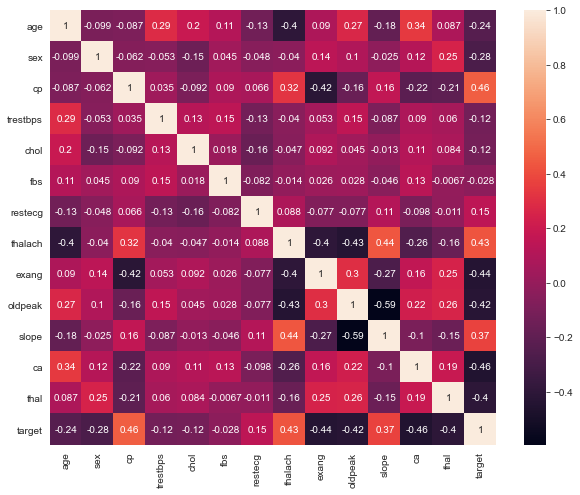

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_import.corr('spearman'), annot=True)

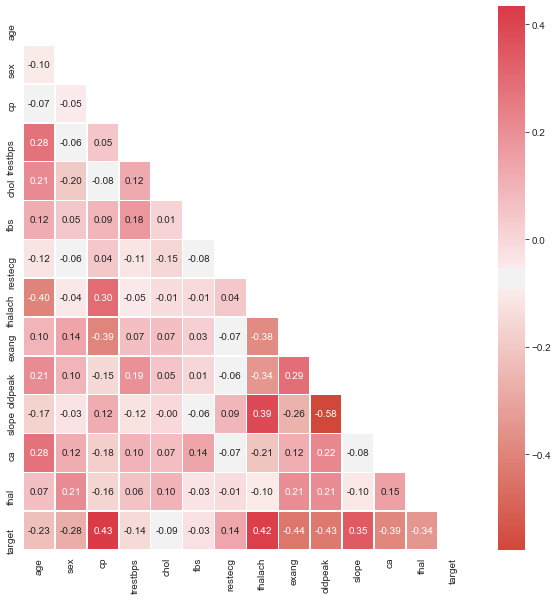

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
dropdata = np.zeros_like(df1.corr())
dropdata[np.triu_indices_from(dropdata)] = True
colormap = sns.diverging_palette(15, 10, as_cmap=True)
sns.heatmap(df1.corr(), cmap=colormap ,linewidths=0.5, annot=True, fmt=".2f", mask=dropdata)
plt.show()

Fitur yang berkorelasi
  - Fitur yang memiliki korelasi cukup tinggi positif terhadap target: chest pain, thalach dan slope
  - Fitur yang memiliki korelasi cukup tinggi negatif terhadap target: exang, oldpeak
  - exang: ketika setelah bergerak, jantung memerlukan banyak darah namun arterti mengalami penyempitan sehingga memperlambat aliran darah sehingga berkorelasi negatif

Fitur yang berkorelasi rendah
  - Fitur yang memiliki korelasi rendah positif terhadap target: restecg
  - Fitur yang memiliki korelasi rendah negatif terhadap target: chol

<Figure size 720x576 with 0 Axes>

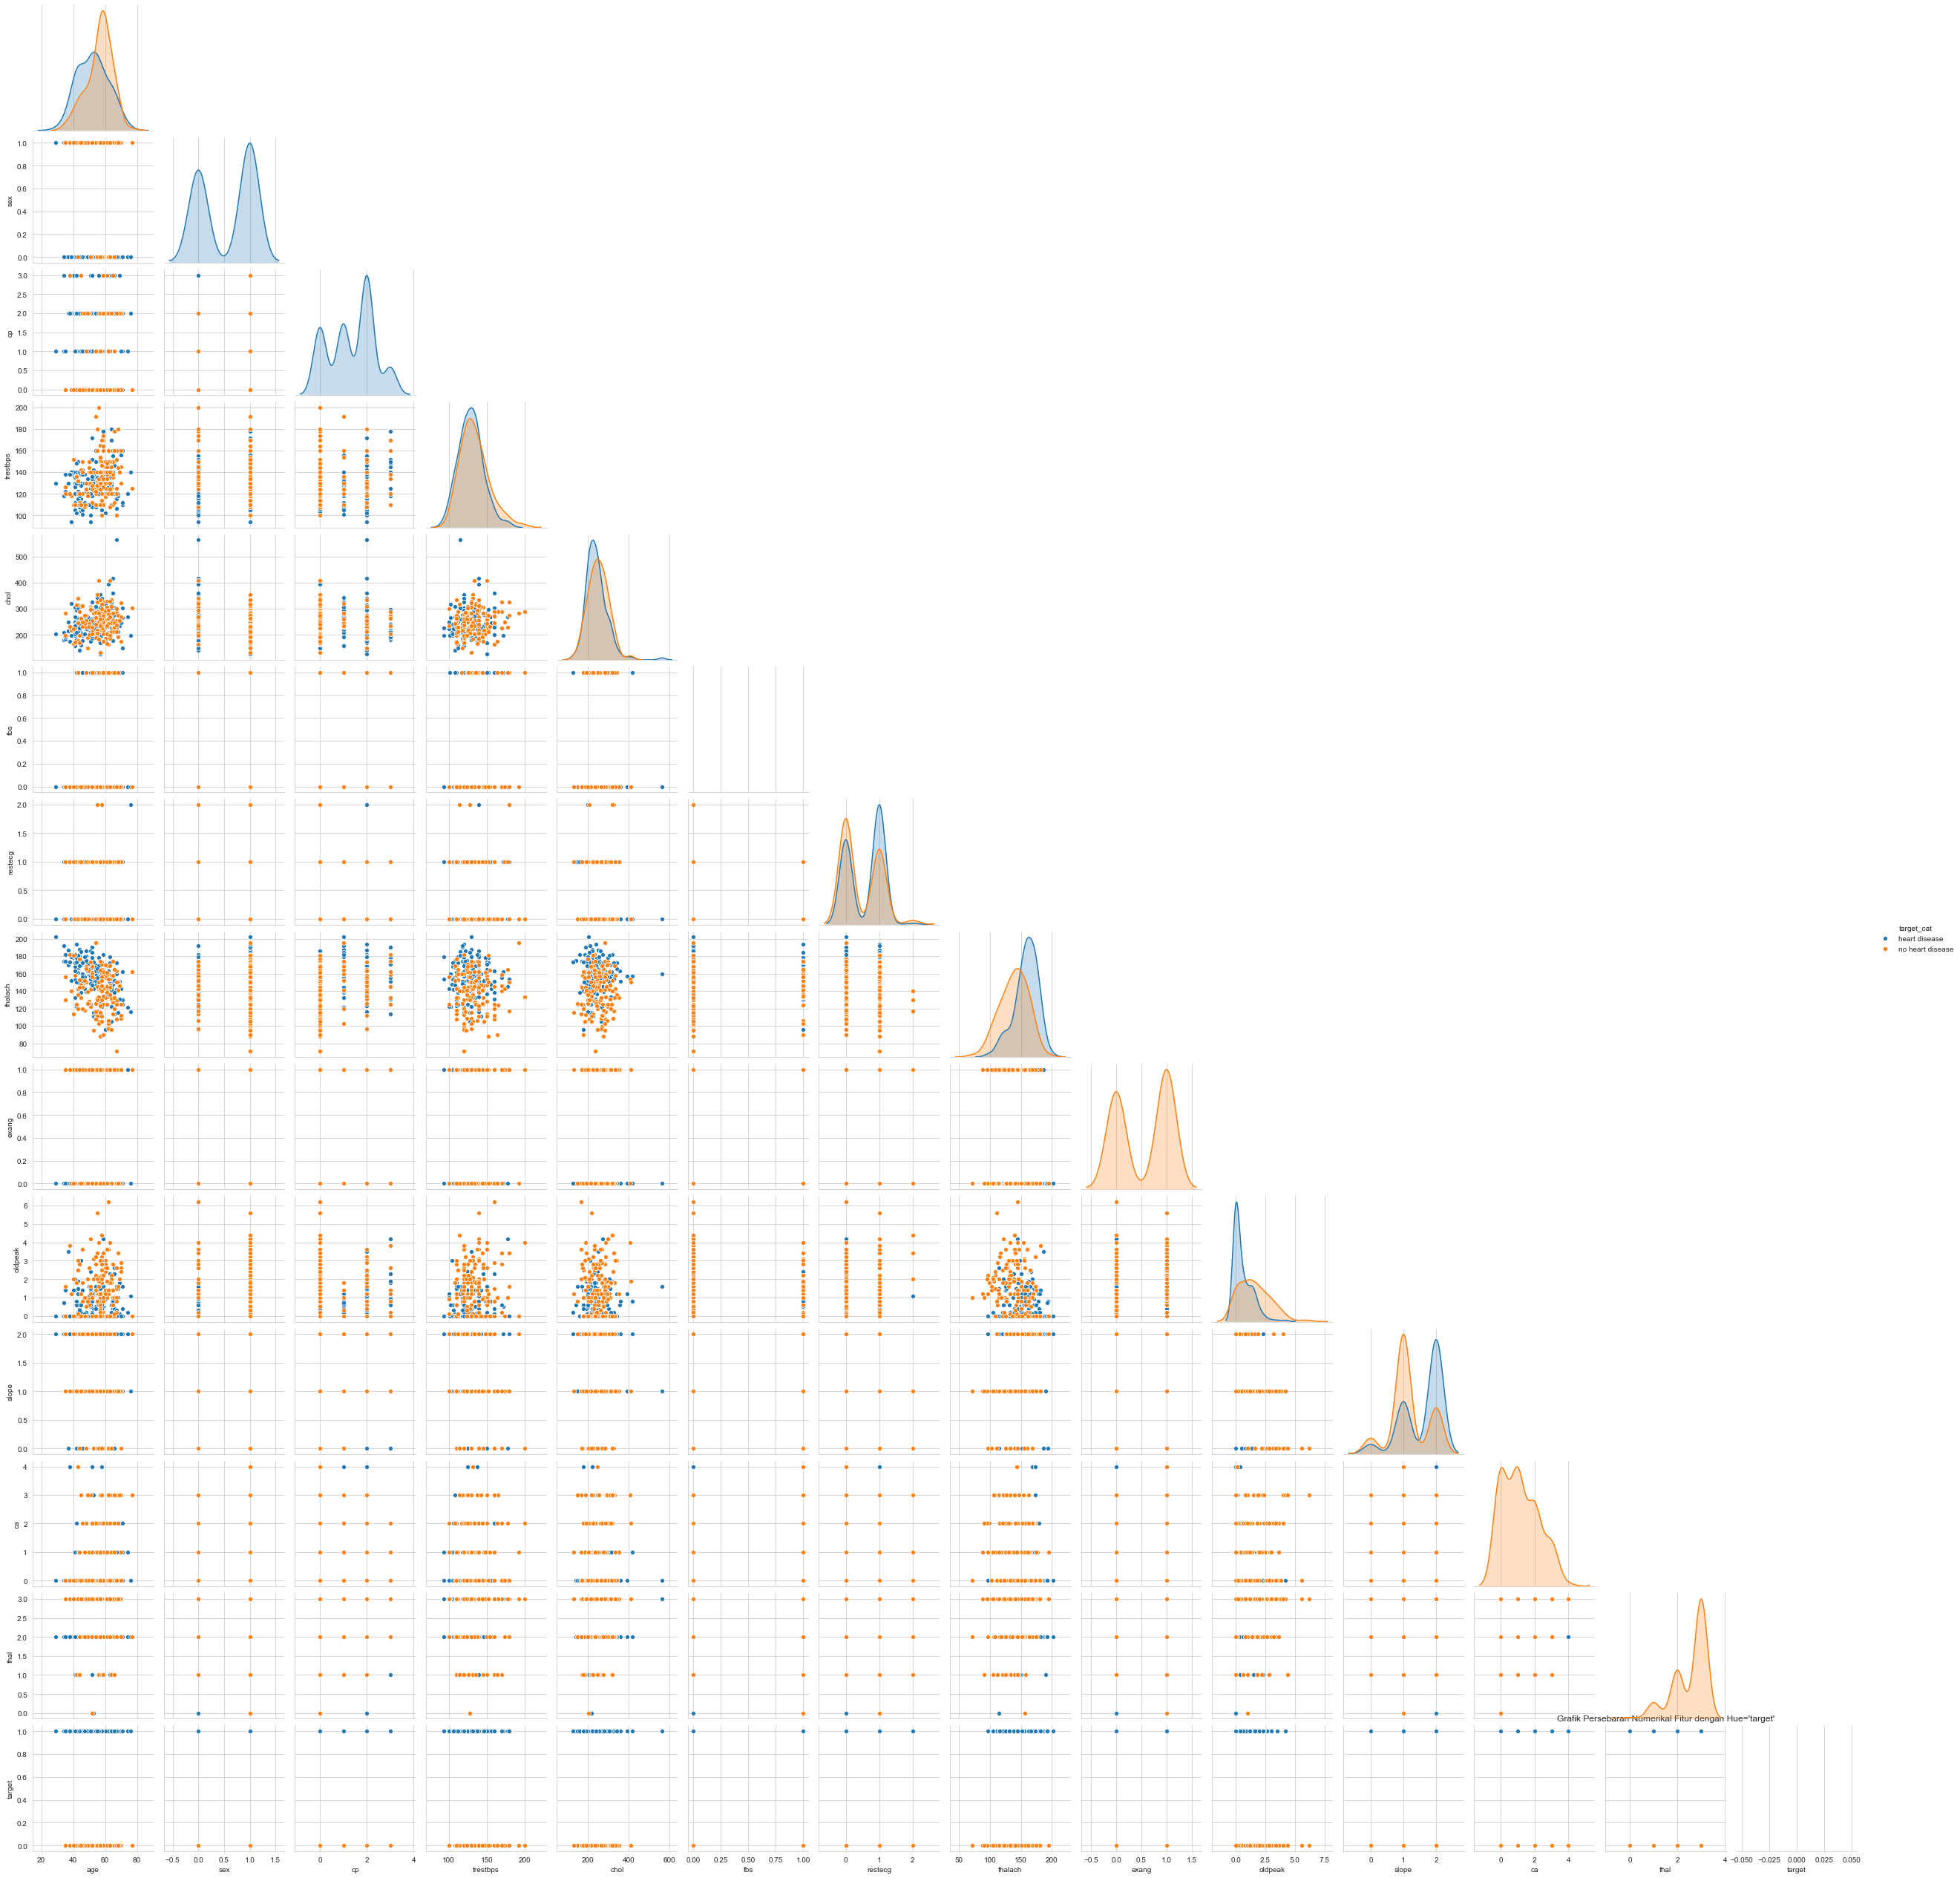

In [27]:
plt.figure(figsize=(10, 8))
sns.pairplot(df1, hue='target_cat', corner=True)
plt.title("Grafik Persebaran Numerikal Fitur dengan Hue='target'")
plt.show()

<Figure size 720x576 with 0 Axes>

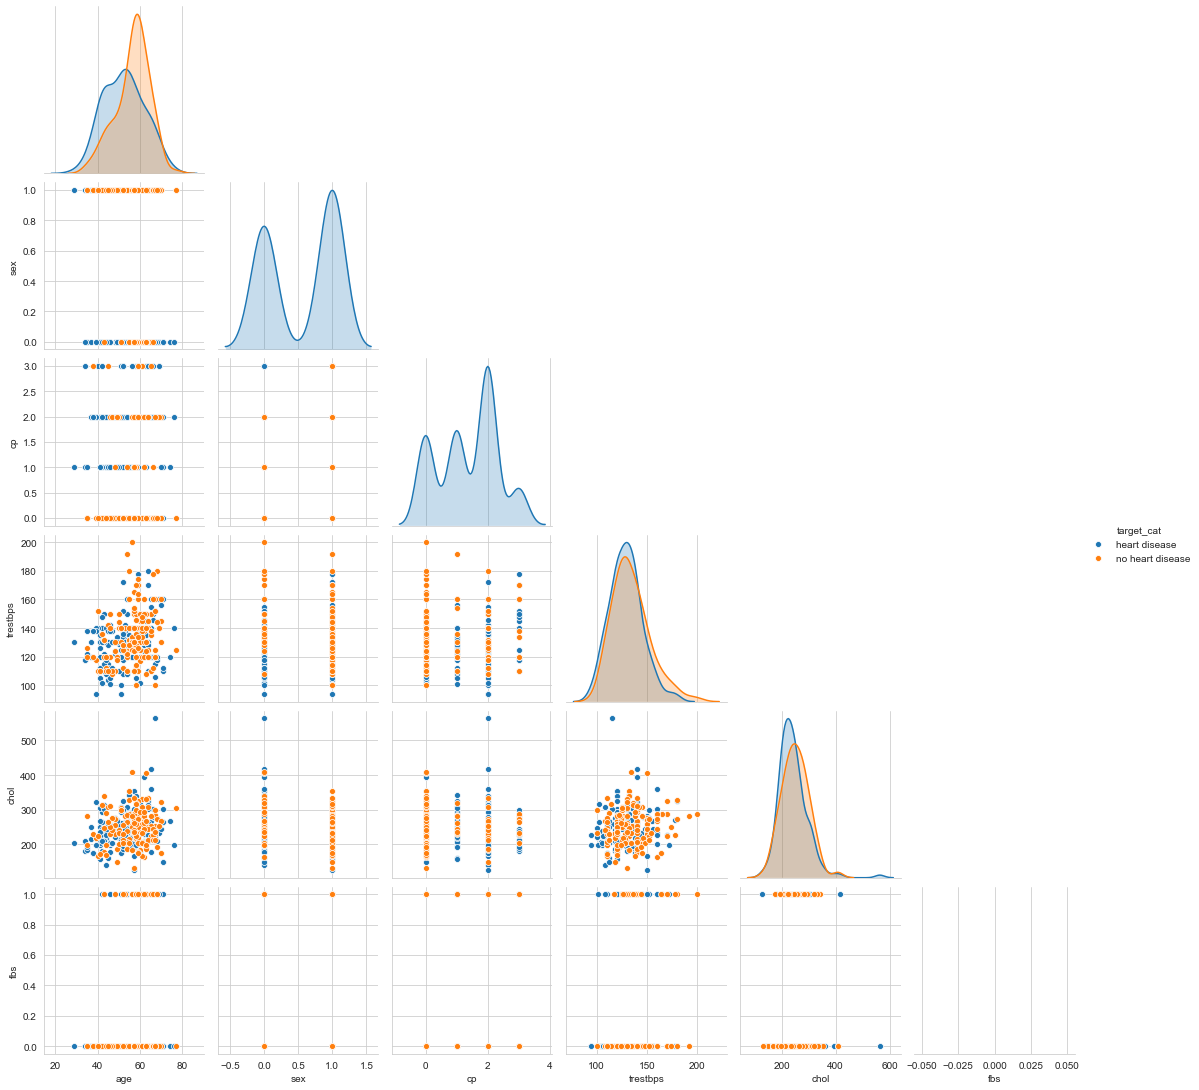

In [28]:
plt.figure(figsize=(10, 8))
sns.pairplot(df1[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'target_cat']], hue='target_cat', corner=True)
plt.show()

<Figure size 720x576 with 0 Axes>

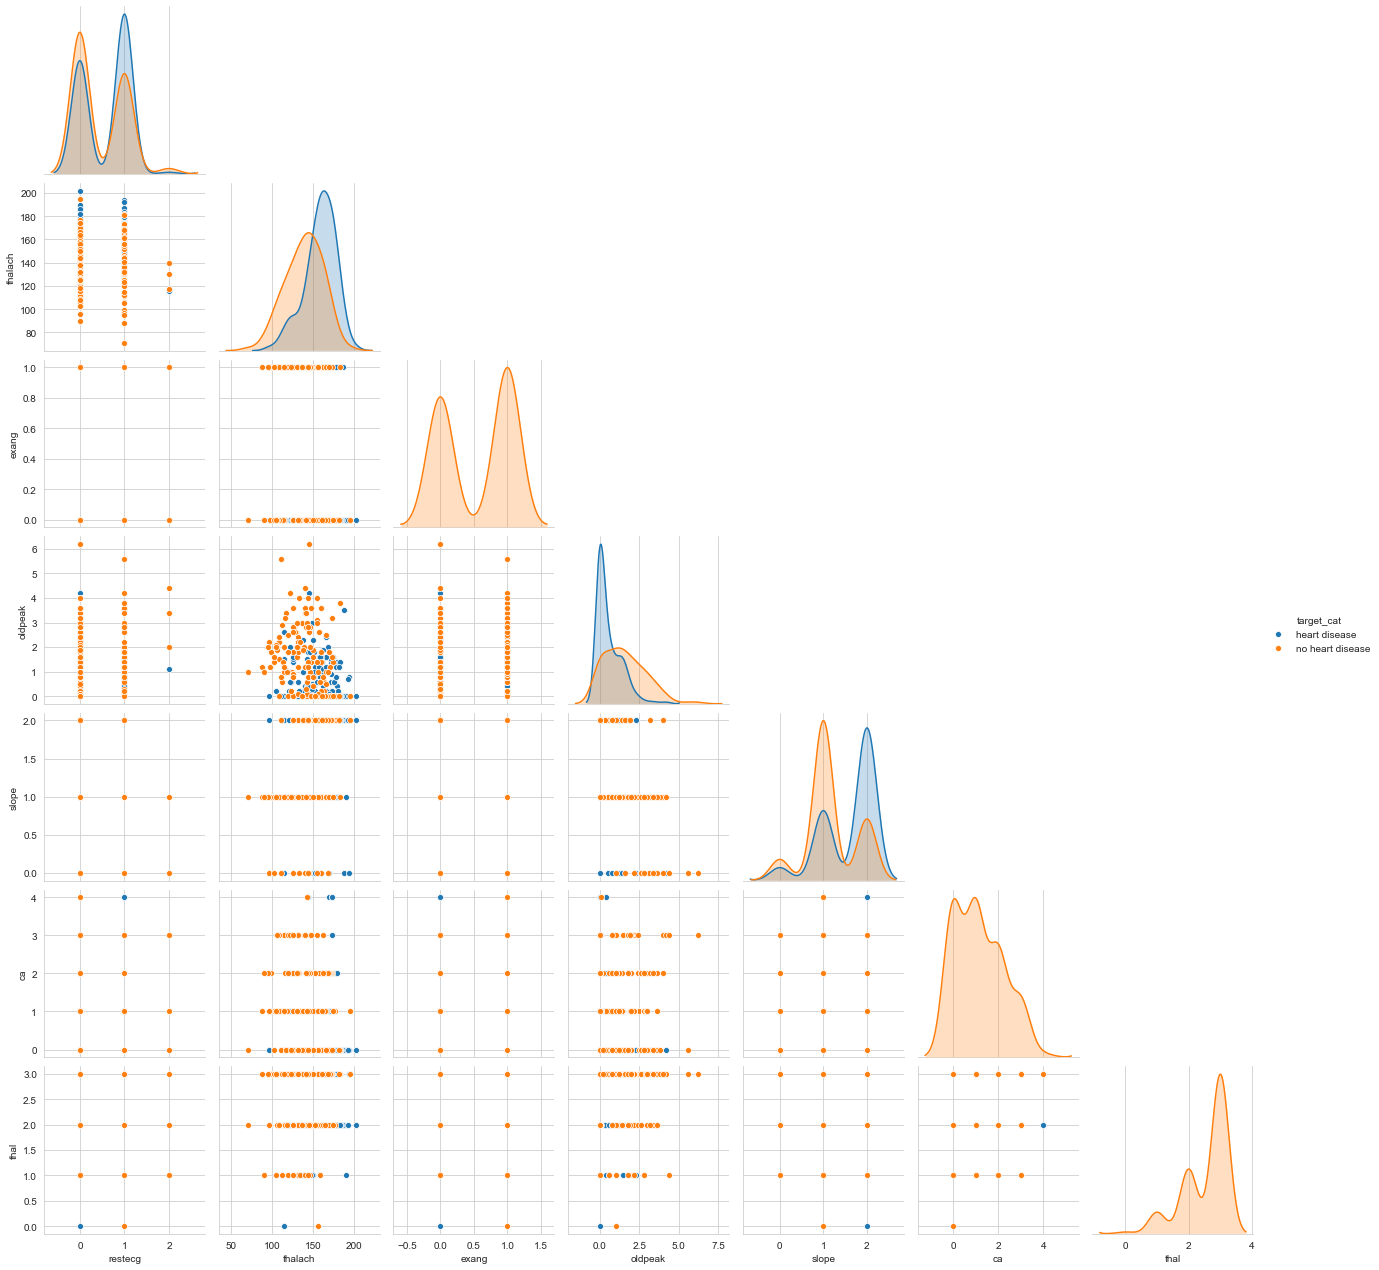

In [29]:
plt.figure(figsize=(10, 8))
sns.pairplot(df1[['restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target_cat']], hue='target_cat', corner=True)
plt.show()

Target
- 0: Biru
- 1: Orange


### Hipotesis Awal

### Age VS Target

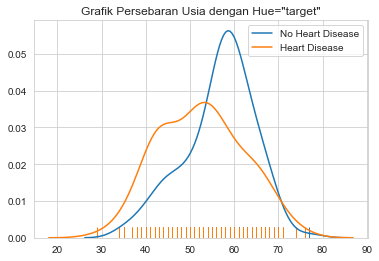

In [30]:
target_0 = df_import.loc[df_import['target'] == 0]
target_1 = df_import.loc[df_import['target'] == 1]

plt.title('Grafik Persebaran Usia dengan Hue="target"')
sns.distplot(target_0[['age']], hist=False, rug=True, label='No Heart Disease')
sns.distplot(target_1[['age']], hist=False, rug=True, label='Heart Disease')
plt.show()

Penyakit jantung sangat rentan di usia sekitar 40 hingga 68. Namun dibawah 30 tahun masih sedikit kasus mengenai penyakit jantung.

### Sex VS Target

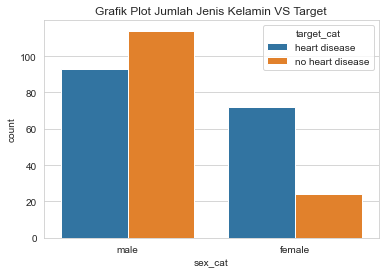

In [31]:
sns.countplot(data= df1, x='sex_cat',hue='target_cat')
plt.title('Grafik Plot Jumlah Jenis Kelamin VS Target')
plt.show()

In [32]:
data_crosstab2 = pd.crosstab(df1['sex_cat'], df1['target_cat'], colnames=['class'])
data_crosstab2

class,heart disease,no heart disease
sex_cat,,
female,72,24
male,93,114


Menurut dataset, jenis kelamin pria lebih rentan terhadap penyakit jantung.

### Chest Pain VS Target
- Fitur yang berkolerasi terhadap target

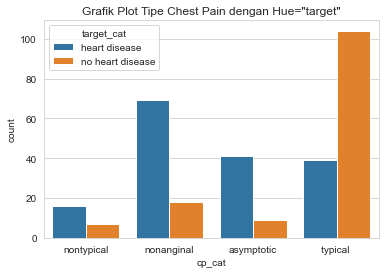

In [33]:
sns.countplot(data= df1, x='cp_cat',hue='target_cat')
plt.title('Grafik Plot Tipe Chest Pain dengan Hue="target"')
plt.show()

In [34]:
x2 = df1.pivot_table(index=['sex_cat', 'cp_cat'], columns='target_cat', values='target', aggfunc='sum').reset_index()
x2

target_cat,sex_cat,cp_cat,heart disease,no heart disease
0,female,asymptotic,16.0,0.0
1,female,nonanginal,34.0,0.0
2,female,nontypical,4.0,NaN
3,female,typical,18.0,0.0
4,male,asymptotic,25.0,0.0
5,male,nonanginal,35.0,0.0
6,male,nontypical,12.0,0.0
7,male,typical,21.0,0.0


Asymptomatic Heart Attack merupakan 

### Cholesterol Level VS Target

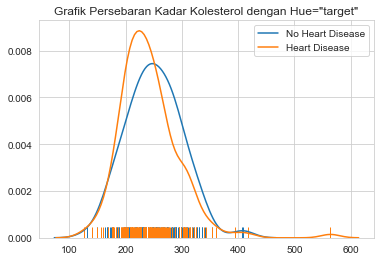

In [35]:
target_0 = df_import.loc[df_import['target'] == 0]
target_1 = df_import.loc[df_import['target'] == 1]

plt.title('Grafik Persebaran Kadar Kolesterol dengan Hue="target"')
sns.distplot(target_0[['chol']], hist=False, rug=True, label='No Heart Disease')
sns.distplot(target_1[['chol']], hist=False, rug=True, label='Heart Disease')
plt.show()

Kolesterol terdiri atas dua jenis, yaitu 
- High Density Lipoprotein (HDL)
    - HDL sering dijuluki kolesterol baik karena berfungsi mencegah terjadinya ateroma atau penyempitan pembuluh darah, akibat penumpukan lemak di dinding arteri pembuluh darah.
    - Kadar HDL yang baik adalah minimal 60 mg/dL. Kadar LDL di bawah 40 mg/dL termasuk rendah.
- Low Density Lipoprotein (LDL)
    - LDL sering dijuluki kolesterol jahat. LDL merupakan salah satu penyebab utama pembentukan ateroma. Ateroma merupakan pemicu penyakit jantung.
    - Kadar LDL yang baik adalah di bawah 100 mg/dL. Kadar LDL di atas 160 mg/dL dianggap tinggi.
    
- Secara umum, kadar kolesterol total yang sehat adalah di bawah 200 mg/dL.
- Kadar kolesterol 200–239 mg/dL dianggap masuk pada ambang batas tinggi. Kadar kolesterol di atas 240 mg/dL dianggap tinggi.


- Dari grafik, ada pasien dengan kadar kolesterol total dibawah 200 namun bisa terkena penyakit jantung dan juga ada kadar kolesterol diatas 240 mg/dL tidak terkena penyakit jantung.


Sumber: https://www.pfimegalife.co.id/literasi-keuangan/kesehatan/read/batas-kolesterol-normal-pria-dan-wanita

In [36]:
pd.crosstab(df1['chol_cat'], df1['target_cat'], colnames=['class'])

class,heart disease,no heart disease
chol_cat,,
1_normal,30,21
2_high,59,38
3_very high,76,79


Kadar kolesterol high dan very high paling banyak menyebabkan penyakit jantung.

In [37]:
df1.pivot_table(index=['sex_cat', 'chol_cat'], columns='target_cat', values='target', aggfunc='count').reset_index()

target_cat,sex_cat,chol_cat,heart disease,no heart disease
0,female,1_normal,12,2
1,female,2_high,19,5
2,female,3_very high,41,17
3,male,1_normal,18,19
4,male,2_high,40,33
5,male,3_very high,35,62


Wanita dengan kolesterol very high paling banyak didiagnosis memiliki penyakit jantung. Namun, bagi pria, kadar kolesterol high dan very high sangat berbahaya yakni dapat menyebabkan penyakit jantung.

### Resting Blood Pressure VS Target

In [38]:
df1[['trestbps', 'target_cat']].groupby(['target_cat']).mean()

,trestbps
target_cat,
heart disease,129.303030
no heart disease,134.398551


Rata-rata Resting Blood Pressure pada penderita heart disease adalah 129.30 tidak berbeda jauh dengan orang yang tidak memiliki penyakit jantung. Maka fitur ini bukan merupakan predictor yang akurat.

### Fasting Blood Sugar VS Target

In [39]:
# df1[['fbs', 'target_cat']].groupby(['target_cat']).sum()

In [40]:
# Fasting Blood Sugar > 120 mg/dL

In [41]:
df1['fbs'].value_counts()

0    258
1     45
Name: fbs, dtype: int64

### Resting Electrocardiographic Results vs Target

In [42]:
df1.restecg.value_counts()

1    152
0    147
2      4
Name: restecg, dtype: int64

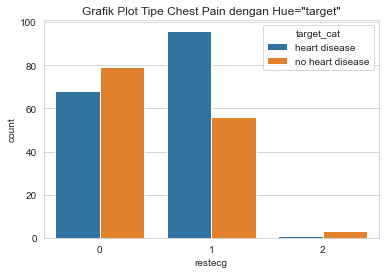

In [43]:
sns.countplot(data= df1, x='restecg',hue='target_cat')
plt.title('Grafik Plot Tipe Chest Pain dengan Hue="target"')
plt.show()

RestECG 0 dan 1 yang paling banyak berpengaruh terhadap prediksi penyakit jantung.

### Thalach VS Target

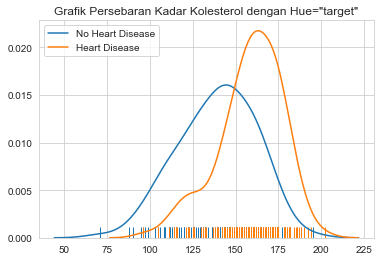

In [44]:
target_0 = df_import.loc[df_import['target'] == 0]
target_1 = df_import.loc[df_import['target'] == 1]

plt.title('Grafik Persebaran Kadar Kolesterol dengan Hue="target"')
sns.distplot(target_0[['thalach']], hist=False, rug=True, label='No Heart Disease')
sns.distplot(target_1[['thalach']], hist=False, rug=True, label='Heart Disease')
plt.show()

Sebagian besar pasien dengan maximum heart rate sekitar 150-175 berpotensi menderita penyakit jantung. Fitur ini merupakan predictor yang cukup bagus.

In [45]:
df1.pivot_table(index=['sex_cat', 'thalach'], columns='target_cat', values='target', aggfunc='count').reset_index()

target_cat,sex_cat,thalach,heart disease,no heart disease
0,female,96,1.0,NaN
1,female,97,NaN,1.0
2,female,106,NaN,1.0
3,female,114,1.0,1.0
4,female,115,2.0,NaN
5,female,116,1.0,NaN
6,female,117,NaN,1.0
7,female,121,1.0,NaN
8,female,122,3.0,NaN
9,female,123,NaN,1.0


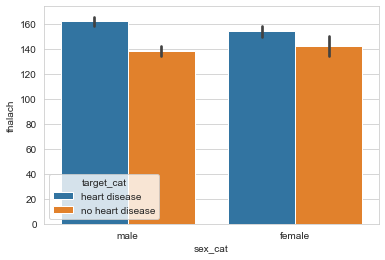

In [46]:
ax = sns.barplot(x="sex_cat", y="thalach", hue="target_cat", data=df1)

## Grafik Distribusi: Target & Handling Imbalance Data

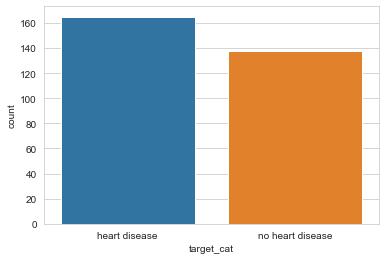

In [47]:
sns.countplot(df1.target_cat)
plt.show()

In [48]:
round(df1.target_cat.value_counts()/len(df1.target_cat) * 100, 2)

heart disease       54.46
no heart disease    45.54
Name: target_cat, dtype: float64

Dataset ini memuat data yang heart disease sebanyak 54.46% dan yang tidak heart disease sebanyak 45.54% sehingga fitur target bukan merupakan data imbalance.

## Feature Engineering & Feature Selection

In [49]:
df2 = df1.copy()

In [50]:
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,sex_cat,target_cat,cp_cat,chol_cat
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,male,heart disease,nontypical,2_high
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,male,heart disease,nonanginal,3_very high
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,female,heart disease,asymptotic,2_high
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,male,heart disease,asymptotic,2_high
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,female,heart disease,typical,3_very high


In [51]:
def slope_cat(x):
    if x == 0:
        return 'downsloping'
    elif x == 1:
        return 'flat'
    else:
        return 'upsloping'
df2['slope_cat'] = df2['slope'].apply(slope_cat)

### Estimated Heart Rate
- Target Heart Rate Manusia: 50 - 70% dari maksimum heart rate/ thalach
- Maksimum rate tergantung dari usia manusia
- Misalkan: Age = 50, maksimum heart rate=220, sehingga estimated maksimum-age related heart rate = 220 - 50 = 170 beats per minute
    - 50% level => 170 x 50% = 85 bpm
    - 70% level => 170 x 70% =  119 bpm
- Oleh karena itu, moderate-intensity physical activity dari 50 tahun harus antara 85 dan 119 selama physical activity.

In [52]:
df2['estimate_HR_50'] = (df2['thalach'] - df2['age']) * 0.5
df2['estimate_HR_70'] = (df2['thalach'] - df2['age']) * 0.7

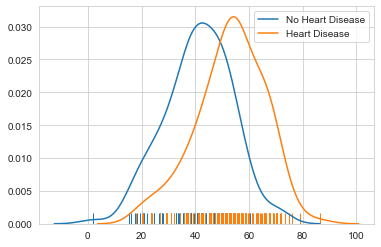

In [53]:
target_0 = df2.loc[df_import['target'] == 0]
target_1 = df2.loc[df_import['target'] == 1]

sns.distplot(target_0[['estimate_HR_50']], hist=False, rug=True, label='No Heart Disease')
sns.distplot(target_1[['estimate_HR_50']], hist=False, rug=True, label='Heart Disease')
plt.show()

Batas bawah Estimated Heart Rate pada orang yang penyakit jantung lebih besar dibanding yang tidak memiliki penyakit jantung.

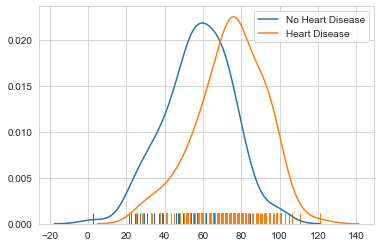

In [54]:
target_0 = df2.loc[df_import['target'] == 0]
target_1 = df2.loc[df_import['target'] == 1]

sns.distplot(target_0[['estimate_HR_70']], hist=False, rug=True, label='No Heart Disease')
sns.distplot(target_1[['estimate_HR_70']], hist=False, rug=True, label='Heart Disease')
plt.show()

Batas atas Estimated Heart Rate pada orang yang penyakit jantung lebih besar dibanding yang tidak memiliki penyakit jantung.

Karena oldpeak dan slope memiliki kolinearitas, maka akan dibuat satu fitur perkalian oldpeak dan slope.

In [55]:
df2['oldpeak_vs_slope'] = df2['oldpeak'] * df2['slope']

In [56]:
df2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,sex_cat,target_cat,cp_cat,chol_cat,slope_cat,estimate_HR_50,estimate_HR_70,oldpeak_vs_slope
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,male,heart disease,nontypical,2_high,downsloping,43.5,60.9,0.0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,male,heart disease,nonanginal,3_very high,downsloping,75.0,105.0,0.0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,female,heart disease,asymptotic,2_high,upsloping,65.5,91.7,2.8
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,male,heart disease,asymptotic,2_high,upsloping,61.0,85.4,1.6
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,female,heart disease,typical,3_very high,upsloping,53.0,74.2,1.2


Karena ingin melihat pengaruh semua fitur terhadap target, maka hampir semua fitur akan digunakan.
Fitur yang tidak digunakan adalah sex_cat, target_cat, cp_cat dan slope_cat.

## Data Preprocessing

### Mengganti Kategorikal fitur (chol_cat) ke numerikal fitur

In [57]:
df3 = pd.get_dummies(df2, columns=['chol_cat'], drop_first=True)

In [58]:
df3.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,sex_cat,target_cat,cp_cat,slope_cat,estimate_HR_50,estimate_HR_70,oldpeak_vs_slope,chol_cat_2_high,chol_cat_3_very high
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,male,heart disease,nontypical,downsloping,43.5,60.9,0.0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,male,heart disease,nonanginal,downsloping,75.0,105.0,0.0,0,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,female,heart disease,asymptotic,upsloping,65.5,91.7,2.8,1,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,male,heart disease,asymptotic,upsloping,61.0,85.4,1.6,1,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,female,heart disease,typical,upsloping,53.0,74.2,1.2,0,1


## Correlation Matrix after Feature Engineering

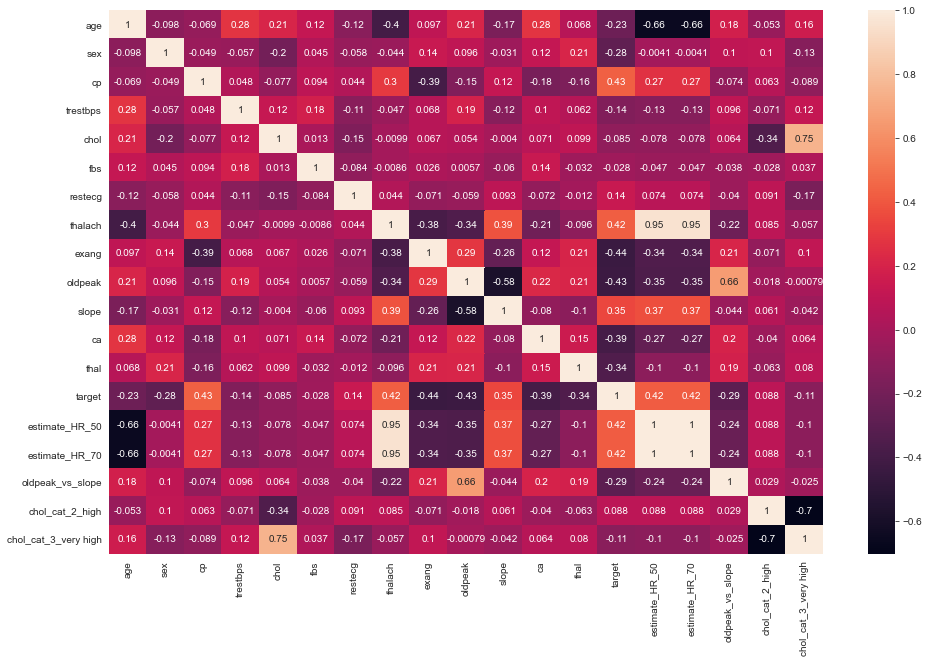

In [59]:
plt.figure(figsize = (16,10))  
sns.heatmap(df3.corr(),annot = True)

## Feature Importance
- Feature importance: yang mempengaruhi ketepatan model menjawab

In [60]:
df_import.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [61]:
X = df_import.iloc[:,:13]
y = df_import.iloc[:, -1]

In [62]:
rf = RandomForestClassifier() 

rf.fit(X, y)

RandomForestClassifier()

In [63]:
# rf.score(X_test, y_test)

In [64]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [65]:
feature_importances

,importance
cp,0.137322
thalach,0.127249
ca,0.121968
oldpeak,0.112027
thal,0.087013
trestbps,0.079617
chol,0.078296
age,0.078146
exang,0.060120
slope,0.046353


### Fitur Pilihan

In [66]:
X = df3.drop(['sex_cat', 'target_cat', 'cp_cat', 'slope_cat'], axis=1)
y = df3['target']

### Scaling

In [67]:
scaler = RobustScaler()

In [68]:
X = scaler.fit_transform(X)

In [69]:
X

array([[ 0.59259259,  0.        ,  1.        , ..., -0.33333333,
         1.        , -1.        ],
       [-1.33333333,  0.        ,  0.5       , ..., -0.33333333,
         0.        ,  0.        ],
       [-1.03703704, -1.        ,  0.        , ...,  1.22222222,
         1.        , -1.        ],
       ...,
       [ 0.96296296,  0.        , -0.5       , ...,  1.55555556,
         0.        , -1.        ],
       [ 0.14814815,  0.        , -0.5       , ...,  0.33333333,
         0.        , -1.        ],
       [ 0.14814815, -1.        ,  0.        , ..., -0.33333333,
         1.        , -1.        ]])

### Splitting Data

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .2, random_state=42)

In [71]:
X_train.shape

(242, 19)

In [72]:
# X_train.head()

In [73]:
X_test.shape

(61, 19)

In [74]:
# X_test.head()

## Machine Learning Model

## 1. Logistic Regression

In [75]:
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

### 1. a. Model Logistic Regression Before Tuning

In [76]:

y_pred_1 = model1.predict(X_test)

model_1_metrics = pd.DataFrame(data = 
             [accuracy_score(y_test, y_pred_1) * 100, 
              recall_score(y_test, y_pred_1) * 100,
              precision_score(y_test, y_pred_1) * 100, 
              roc_auc_score(y_test, y_pred_1) * 100,
              f1_score(y_test, y_pred_1) * 100],
            index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
            columns = ['Score Logistic Regression Default(%)'])
model_1_metrics

,Score Logistic Regression Default(%)
accuracy,100.0
recall,100.0
precision,100.0
roc_auc_score,100.0
f1_score,100.0


In [77]:
model_1_train_test = pd.DataFrame(data = [model1.score(X_train, y_train) * 100,
                    model1.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score Logistic Regression Default (%)']
            )
model_1_train_test

,Score Logistic Regression Default (%)
Model Score in Data Train,100.0
Model Score in Data Test,100.0


### 1. b. Model Logistic Regression After Tuning

In [78]:
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinier', 'sag', 'saga']
max_iter = [1, 10, 100, 1000, 10000]
multi_class=['auto', 'ovr', 'multinomial']

paramlog = {
    'penalty': penalty, 
    'solver': solver, 
    'max_iter': max_iter,
    'multi_class': multi_class}
paramlog

{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'solver': ['newton-cg', 'lbfgs', 'liblinier', 'sag', 'saga'],
 'max_iter': [1, 10, 100, 1000, 10000],
 'multi_class': ['auto', 'ovr', 'multinomial']}

In [79]:
model1_GS = GridSearchCV(model1, paramlog, cv=5, n_jobs=-1, verbose=1)

In [80]:
model1_GS.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   12.9s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [1, 10, 100, 1000, 10000],
                         'multi_class': ['auto', 'ovr', 'multinomial'],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinier', 'sag',
                                    'saga']},
             verbose=1)

In [81]:
model1_GS.best_params_

{'max_iter': 10, 'multi_class': 'auto', 'penalty': 'l1', 'solver': 'saga'}

In [82]:
# Memasukan best param
model1_tuning = LogisticRegression(solver='saga', penalty = 'l1', max_iter = 1, multi_class='ovr')
model1_tuning.fit(X_train, y_train)

LogisticRegression(max_iter=1, multi_class='ovr', penalty='l1', solver='saga')

In [83]:
y_pred1_tuning = model1_tuning.predict(X_test)

model_1_tuning_metrics = pd.DataFrame(data = [
    accuracy_score(y_test, y_pred1_tuning) * 100, 
    recall_score(y_test, y_pred1_tuning) * 100,
    precision_score(y_test, y_pred1_tuning) * 100, 
    roc_auc_score(y_test, y_pred1_tuning) * 100,
    f1_score(y_test, y_pred1_tuning) * 100],
index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
            columns = ['Score Logistic Regression Tuning (%)'])
model_1_tuning_metrics

,Score Logistic Regression Tuning (%)
accuracy,96.721311
recall,100.000000
precision,94.285714
roc_auc_score,96.428571
f1_score,97.058824


In [84]:
model_1_tuning_train_test = pd.DataFrame(data = [model1_tuning.score(X_train, y_train)*100,
                    model1_tuning.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score Logistic Regression Tuning (%)']
            )
model_1_tuning_train_test

,Score Logistic Regression Tuning (%)
Model Score in Data Train,93.801653
Model Score in Data Test,96.721311


## 2. KNN Classifier

In [85]:
# scaling mempengaruhi KNN
# n neighbors: default 5
model2 = KNeighborsClassifier()

In [86]:
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [87]:
y_pred_2 = model2.predict(X_test)

### 2.a. Model KNN Before Tuning

In [88]:

y_pred_2 = model2.predict(X_test)

model_2_metrics = pd.DataFrame(data = 
             [accuracy_score(y_test, y_pred_2) * 100, 
              recall_score(y_test, y_pred_2) * 100,
              precision_score(y_test, y_pred_2) * 100, 
              roc_auc_score(y_test, y_pred_2) * 100,
              f1_score(y_test, y_pred_2) * 100],
            index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
            columns = ['Score KNN Default(%)'])
model_2_metrics

,Score KNN Default(%)
accuracy,93.442623
recall,100.000000
precision,89.189189
roc_auc_score,92.857143
f1_score,94.285714


In [89]:
model_2_train_test = pd.DataFrame(
        data = [model2.score(X_train, y_train) * 100,
                model2.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score KNN Default (%)']
            )
model_2_train_test

,Score KNN Default (%)
Model Score in Data Train,91.735537
Model Score in Data Test,93.442623


### 2.b. Model KNN After Tuning

In [90]:
k = round((len(X_train)) ** 0.5) + 1

paramKNN = {
    'n_neighbors' : range(k-round(k/2) , k*2), 
    'weights' : ['uniform', 'distance'], 
    'p': [2, 1]}

In [91]:
# model2_tuning = KNeighborsClassifier()
model2_GS= GridSearchCV(model2, paramKNN, cv = 5, n_jobs=-1, verbose=1)
model2_GS.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(9, 34), 'p': [2, 1],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [92]:
model2_GS.best_params_

{'n_neighbors': 12, 'p': 1, 'weights': 'distance'}

In [93]:
# Memasukan best param
model2_tuning = KNeighborsClassifier(n_neighbors=15, weights='distance')
model2_tuning.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=15, weights='distance')

In [94]:
y_pred2_tuning = model2_tuning.predict(X_test)

model_2_tuning_metrics = pd.DataFrame(data = [
    accuracy_score(y_test, y_pred2_tuning) * 100, 
    recall_score(y_test, y_pred2_tuning) * 100,
    precision_score(y_test, y_pred2_tuning) * 100, 
    roc_auc_score(y_test, y_pred2_tuning) * 100,
    f1_score(y_test, y_pred2_tuning) * 100],
index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
            columns = ['Score KNN Tuning (%)'])
model_2_tuning_metrics

,Score KNN Tuning (%)
accuracy,91.803279
recall,100.000000
precision,86.842105
roc_auc_score,91.071429
f1_score,92.957746


In [95]:
model_2_tuning_train_test = pd.DataFrame(data = [model2_tuning.score(X_train, y_train)*100,
                    model2_tuning.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score KNN Tuning (%)']
            )
model_2_tuning_train_test

,Score KNN Tuning (%)
Model Score in Data Train,100.000000
Model Score in Data Test,91.803279


## 3. Random Forest Classifier

In [96]:
model3 = RandomForestClassifier()

In [97]:
model3.fit(X_train, y_train)

RandomForestClassifier()

### 3.a. Random Forest Before Tuning

In [98]:

y_pred_3 = model3.predict(X_test)

model_3_metrics = pd.DataFrame(data = 
             [accuracy_score(y_test, y_pred_3) * 100, 
              recall_score(y_test, y_pred_3) * 100,
              precision_score(y_test, y_pred_3) * 100, 
              roc_auc_score(y_test, y_pred_3) * 100,
              f1_score(y_test, y_pred_3) * 100],
            index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
            columns = ['Score Random Forest Regression Default(%)'])
model_3_metrics

,Score Random Forest Regression Default(%)
accuracy,100.0
recall,100.0
precision,100.0
roc_auc_score,100.0
f1_score,100.0


In [99]:
model_3_train_test = pd.DataFrame(
        data = [model3.score(X_train, y_train) * 100,
                model3.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score Random Forest Regression Default (%)']
            )
model_3_train_test

,Score Random Forest Regression Default (%)
Model Score in Data Train,100.0
Model Score in Data Test,100.0


### 3.b. Random Forest After Tuning

In [100]:
paramRF = {
    'n_estimators': [100, 200, 250, 300, 400, 500],
    'max_depth': range(1, 10),
    'max_features': ['sqrt', 'log2']}

In [ ]:
model3_GS = GridSearchCV(model3, paramRF, cv=5, n_jobs=-1, verbose=1)
model3_GS.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min


In [ ]:
model3_GS.best_params_

In [ ]:
# Memasukan best param
model3_tuning = RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=400)
model3_tuning.fit(X_train, y_train)

In [ ]:
y_pred3_tuning = model3_tuning.predict(X_test)

model_3_tuning_metrics = pd.DataFrame(data = [
    accuracy_score(y_test, y_pred3_tuning) * 100, 
    recall_score(y_test, y_pred3_tuning) * 100,
    precision_score(y_test, y_pred3_tuning) * 100, 
    roc_auc_score(y_test, y_pred3_tuning) * 100,
    f1_score(y_test, y_pred3_tuning) * 100],
index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
            columns = ['Score Random Forest Tuning (%)'])
model_3_tuning_metrics

In [ ]:
model_3_tuning_train_test = pd.DataFrame(data = [model3_tuning.score(X_train, y_train)*100,
                    model3_tuning.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score Random Forest Tuning (%)']
            )
model_3_tuning_train_test

<!-- ## Accuracy
Jika Data Imbalance ==> Akurasi Tidak bisa digunakan karena BIAS, Kecuali Data Memiliki Feature yang Distinct
(Berbeda secara signifikan antar Class)

Akurasi adalah Perbadingan **SELURUH TEBAKAN BENAR** dibanding **SELURUH DATA**

\begin{equation}
Accuracy = \frac{TP+TN}{(TP+FP + TN+FN)}
\end{equation}

## Precision

- Jika Target Kita mendapatkan **False Positive Sekecil** Mungkin

Contoh :
   - Klasifikasi Email SPAM dan NON - SPAM
   - Kebanyakan Email Non-SPAM hanya ada beberapa yang SPAM
   - Efek Akan Fatal JIka EMail Non - SPAM kita anggap SPAM (False Positive)
   
   \begin{equation}
Precision = \frac{TP}{(TP+FP)}
\end{equation}

- **Precision Positif** adalah **JUMLAH TEBAKAN BENAR DI KELAS POSITIF** dibanding **SELURUH _TEBAKAN_ POSITIF**

## Recall
- Jika Target Kita mendapatkan **False Negative Sekecil Mungkin**

COntoh :

- Klasifikasi Covid dan Non-Covid (Untuk Mendeteksi Covid)
- Dataset Kebanyakan adalah Non-Covid dibanding Covid
- Efek Akan Fatal Jika Pasien **Covid** kita Anggap **Non-Covid**

\begin{equation}
Recall = \frac{TP}{(TP+FN)}
\end{equation}

- **Precision Positif** adalah **JUMLAH TEBAKAN BENAR DI KELAS POSITIF** dibanding **SELURUH DATA _AKTUAL_ POSITIF** -->

## Metrics

### 1. Logistic Regression Before Tuning and After Tuning

In [ ]:
# Before Tuning: y_pred_1
print(classification_report(y_test, y_pred_1))

In [ ]:
# Logistic Regression Before Tuning
cm = confusion_matrix(y_test, y_pred_1, labels=[1, 0])
df = pd.DataFrame(cm, columns=['Pred 1', 'Pred 0'], index=['Act 1', 'Act 0'])
sns.heatmap(df, annot=True)

In [ ]:
# After Tuning: y_pred1_tuning
print(classification_report(y_test, y_pred1_tuning))

In [ ]:
# Logistic Regression After Tuning
cm = confusion_matrix(y_test, y_pred1_tuning, labels=[1, 0])
df = pd.DataFrame(cm, columns=['Pred 1', 'Pred 0'], index=['Act 1', 'Act 0'])
sns.heatmap(df, annot=True)

### 2. KNN Before Tuning and After Tuning

In [ ]:
# Before Tuning: y_pred_2
print(classification_report(y_test, y_pred_2))

In [ ]:
# KNN Before Tuning
cm = confusion_matrix(y_test, y_pred_2, labels=[1, 0])
df = pd.DataFrame(cm, columns=['Pred 1', 'Pred 0'], index=['Act 1', 'Act 0'])
sns.heatmap(df, annot=True)

In [ ]:
# After Tuning: y_pred2_tuning
print(classification_report(y_test, y_pred2_tuning))

In [ ]:
# KNN After Tuning
cm = confusion_matrix(y_test, y_pred2_tuning, labels=[1, 0])
df = pd.DataFrame(cm, columns=['Pred 1', 'Pred 0'], index=['Act 1', 'Act 0'])
sns.heatmap(df, annot=True)

### 3. Random Forest Regression Before Tuning and After Tuning

In [ ]:
# Before Tuning: y_pred_3
print(classification_report(y_test, y_pred_3))

In [ ]:
# RF Before Tuning
cm = confusion_matrix(y_test, y_pred_3, labels=[1, 0])
df = pd.DataFrame(cm, columns=['Pred 1', 'Pred 0'], index=['Act 1', 'Act 0'])
sns.heatmap(df, annot=True)

In [ ]:
# After Tuning: y_pred3_tuning
print(classification_report(y_test, y_pred3_tuning))

In [ ]:
# RF After Tuning
cm = confusion_matrix(y_test, y_pred3_tuning, labels=[1, 0])
df = pd.DataFrame(cm, columns=['Pred 1', 'Pred 0'], index=['Act 1', 'Act 0'])
sns.heatmap(df, annot=True)

## Perbandingan Model

In [ ]:
probs1 = model1.predict_proba(X_test)
probs2 = model2.predict_proba(X_test)
probs3 = model3.predict_proba(X_test)
probs4 = model1_tuning.predict_proba(X_test)
probs5 = model2_tuning.predict_proba(X_test)
probs6 = model3_tuning.predict_proba(X_test)

In [ ]:
preds1 = probs1[:, 1]
preds2 = probs2[:, 1]
preds3 = probs3[:, 1]
preds4 = probs4[:, 1]
preds5 = probs5[:, 1]
preds6 = probs6[:, 1]
fpr1, tpr1, threshold1 = roc_curve(y_test, preds1)
fpr2, tpr2, threshold2 = roc_curve(y_test, preds2)
fpr3, tpr3, threshold3 = roc_curve(y_test, preds3)
fpr4, tpr4, threshold4 = roc_curve(y_test, preds4)
fpr5, tpr5, threshold5 = roc_curve(y_test, preds5)
fpr6, tpr6, threshold6 = roc_curve(y_test, preds6)

In [ ]:
sc1 = round(auc(fpr1, tpr1),2)
sc2 = round(auc(fpr2, tpr2),2)
sc3 = round(auc(fpr3, tpr3),2)
sc4 = round(auc(fpr4, tpr4),2)
sc5 = round(auc(fpr5, tpr5),2)
sc6 = round(auc(fpr6, tpr6),2)
sc1

In [ ]:
plt.figure(figsize=(10,8))

plt.title("Receiver Operator Characteristic")
plt.plot(fpr1, tpr1, 'b', label=f'AUC Logistic Regression= {sc1}')
plt.plot(fpr2, tpr2, 'g', label=f'AUC KNN= {sc2}')
plt.plot(fpr3, tpr3, 'k', label=f'AUC Random Forest Classifier= {sc3}')
plt.plot(fpr4, tpr4, 'y', label=f'AUC LogReg Tuning= {sc4}')
plt.plot([0,1], [0,1], 'r-.')

plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(loc=2)
plt.ylabel("True Positive Rates")
plt.xlabel("False Positive Rates")
plt.show()

In [ ]:
pd.concat([model_1_metrics, model_1_tuning_metrics, model_2_metrics, model_2_tuning_metrics, model_3_metrics, model_3_tuning_metrics], axis=1)

Karena serangan jantung itu bisa saja mendadak, maka perhitungan dilakukan dengan memilih Recall yang paling Tinggi. Jangan sampai orang yang memiliki penyakit jantung tidak terprediksi memiliki penyakit jantung. Oleh karena itu, model yang dipakai adalah Random Forest Regressor setelah tuning. Dengan Recall hampir 97%. (Menghindari FN sekecil mungkin)

## Kesimpulan

- Area under ROC semua model adalah sekitar 87% yang berarti sangat memuaskan.
- Model yang dipilih adalah model Random Forest dengan Tuning karena memiliki Recall tinggi guna mencegah orang yang memiliki penyakit jantung tidak terprediksi memiliki penyakit jantung. Agar pasien dapat mengubah gaya hidup sehat sehingga jantungnya menjadi sehat.
- Jenis kelamin pria lebih rentan menderita penyakit jantung dalam kasus dataset ini
- Ada pasien dengan kadar kolesterol total dibawah 200 namun bisa terkena penyakit jantung dan juga ada kadar kolesterol diatas 240 mg/dL tidak terkena penyakit jantung.
- Penyakit jantung sangat rentan di usia sekitar 40 hingga 68. Namun dibawah 30 tahun masih sedikit kasus mengenai penyakit jantung.
- Lima fitur yang mempengaruhi ketepatan model: chest pain, ca, oldpeak, thal dan age

### Export Model 

In [ ]:
import pickle
import joblib

with open('heartModel', 'wb') as ML:
    pickle.dump(model3_tuning, ML)

In [ ]:
X_train[0]